In [63]:
import pandas as pd
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

In [64]:
train_data = pd.read_csv('train.csv')
test_data = pd.read_csv('test.csv')

In [65]:
train_data.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


# Data Preprocessing

In [66]:
train_data.info()
print(train_data['person_home_ownership'].unique())
print(train_data['loan_intent'].unique())
print(train_data['loan_grade'].unique())
print(train_data['cb_person_default_on_file'].unique())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  object 
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  object 
 6   loan_grade                  58645 non-null  object 
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  object 
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(6), object

In [67]:
# Person_home_ownership
def Ownership(data):
    ownership_mapping = {
        'OTHER': 0,
        'RENT': 1,
        'MORTGAGE': 2,
        'OWN': 3
    }
    data['person_home_ownership'] = data['person_home_ownership'].map(ownership_mapping)

def Intent(data):
    intent_mapping = {
        'DEBTCONSOLIDATION': 6,
        'VENTURE': 0,
        'EDUCATION': 1,
        'PERSONAL': 2,
        'HOMEIMPROVEMENT': 3,
        'MEDICAL': 4
    }
    data['loan_intent'] = data['loan_intent'].map(intent_mapping)

def grade(data):
    grading = {
        'A': 0,
        'B': 1,
        'C': 2,
        'D': 3,
        'E': 4,
        'F': 5,
        'G': 6,
    }
    data['loan_grade'] = data['loan_grade'].map(grading)

def mpping(data):
    mpping = {
        'Y': 1,
        'N': 0,
    }
    data['cb_person_default_on_file'] = data['cb_person_default_on_file'].map(mpping)

Ownership(train_data)
Intent(train_data)
grade(train_data)
mpping(train_data)


In [68]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58645 entries, 0 to 58644
Data columns (total 13 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   id                          58645 non-null  int64  
 1   person_age                  58645 non-null  int64  
 2   person_income               58645 non-null  int64  
 3   person_home_ownership       58645 non-null  int64  
 4   person_emp_length           58645 non-null  float64
 5   loan_intent                 58645 non-null  int64  
 6   loan_grade                  58645 non-null  int64  
 7   loan_amnt                   58645 non-null  int64  
 8   loan_int_rate               58645 non-null  float64
 9   loan_percent_income         58645 non-null  float64
 10  cb_person_default_on_file   58645 non-null  int64  
 11  cb_person_cred_hist_length  58645 non-null  int64  
 12  loan_status                 58645 non-null  int64  
dtypes: float64(3), int64(10)
memory

# Train Test Split

In [69]:
X = train_data.drop(columns=['loan_status'])
y = train_data['loan_status']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Exploratory Data Analysis

In [70]:
train_data_og = pd.read_csv('train.csv')
train_data_og.head()

,id,person_age,person_income,person_home_ownership,person_emp_length,loan_intent,loan_grade,loan_amnt,loan_int_rate,loan_percent_income,cb_person_default_on_file,cb_person_cred_hist_length,loan_status
0,0,37,35000,RENT,0.0,EDUCATION,B,6000,11.49,0.17,N,14,0
1,1,22,56000,OWN,6.0,MEDICAL,C,4000,13.35,0.07,N,2,0
2,2,29,28800,OWN,8.0,PERSONAL,A,6000,8.90,0.21,N,10,0
3,3,30,70000,RENT,14.0,VENTURE,B,12000,11.11,0.17,N,5,0
4,4,22,60000,RENT,2.0,MEDICAL,A,6000,6.92,0.10,N,3,0


## Outlier Removal

<Axes: xlabel='loan_status', ylabel='person_age'>

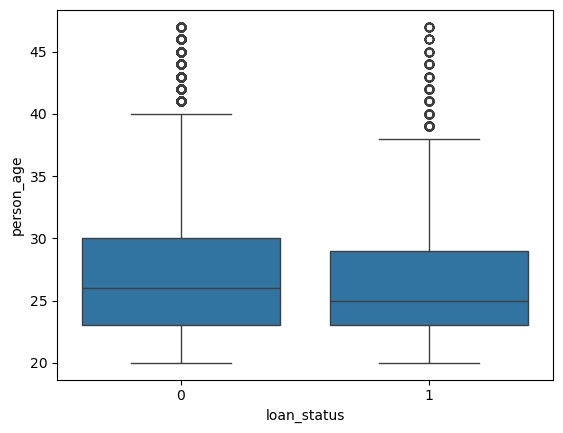

In [73]:
# BoxPlot for Age and loan percent income
import seaborn as sns

Q1 = train_data_og['person_age'].quantile(0.25)
Q3 = train_data_og['person_age'].quantile(0.75)
IQR = Q3 - Q1

# Calculate outlier bounds
lower_bound = Q1 - 2.5 * IQR
upper_bound = Q3 + 2.5 * IQR

# Filter data to remove outliers
train_data_og = train_data_og[(train_data_og['person_age'] >= lower_bound) & (train_data_og['person_age'] <= upper_bound)]

sns.boxplot(x='loan_status',y='person_age',data=train_data_og)

In [38]:
status_counts = train_data_og.groupby(['loan_grade', 'loan_status'])['loan_status'].count().unstack(fill_value=0)
status_counts['ratio_1_to_0'] = status_counts[1] / status_counts[0]
print(status_counts[[1, 0, 'ratio_1_to_0']])

loan_status     1      0  ratio_1_to_0
loan_grade                            
A            1010  19736      0.051176
B            2052  18113      0.113289
C            1480   9419      0.157129
D            2933   2012      1.457753
E             624    371      1.681941
F              84     57      1.473684
G              27      6      4.500000


In [39]:
status_counts = train_data_og.groupby(['loan_intent', 'loan_status'])['loan_status'].count().unstack(fill_value=0)
status_counts['ratio_1_to_0'] = status_counts[1] / status_counts[0]
print(status_counts[[1, 0, 'ratio_1_to_0']])

loan_status           1      0  ratio_1_to_0
loan_intent                                 
DEBTCONSOLIDATION  1706   7366      0.231605
EDUCATION          1313  10905      0.120403
HOMEIMPROVEMENT    1080   5140      0.210117
MEDICAL            1911   8899      0.214743
PERSONAL           1284   8382      0.153185
VENTURE             916   9022      0.101530


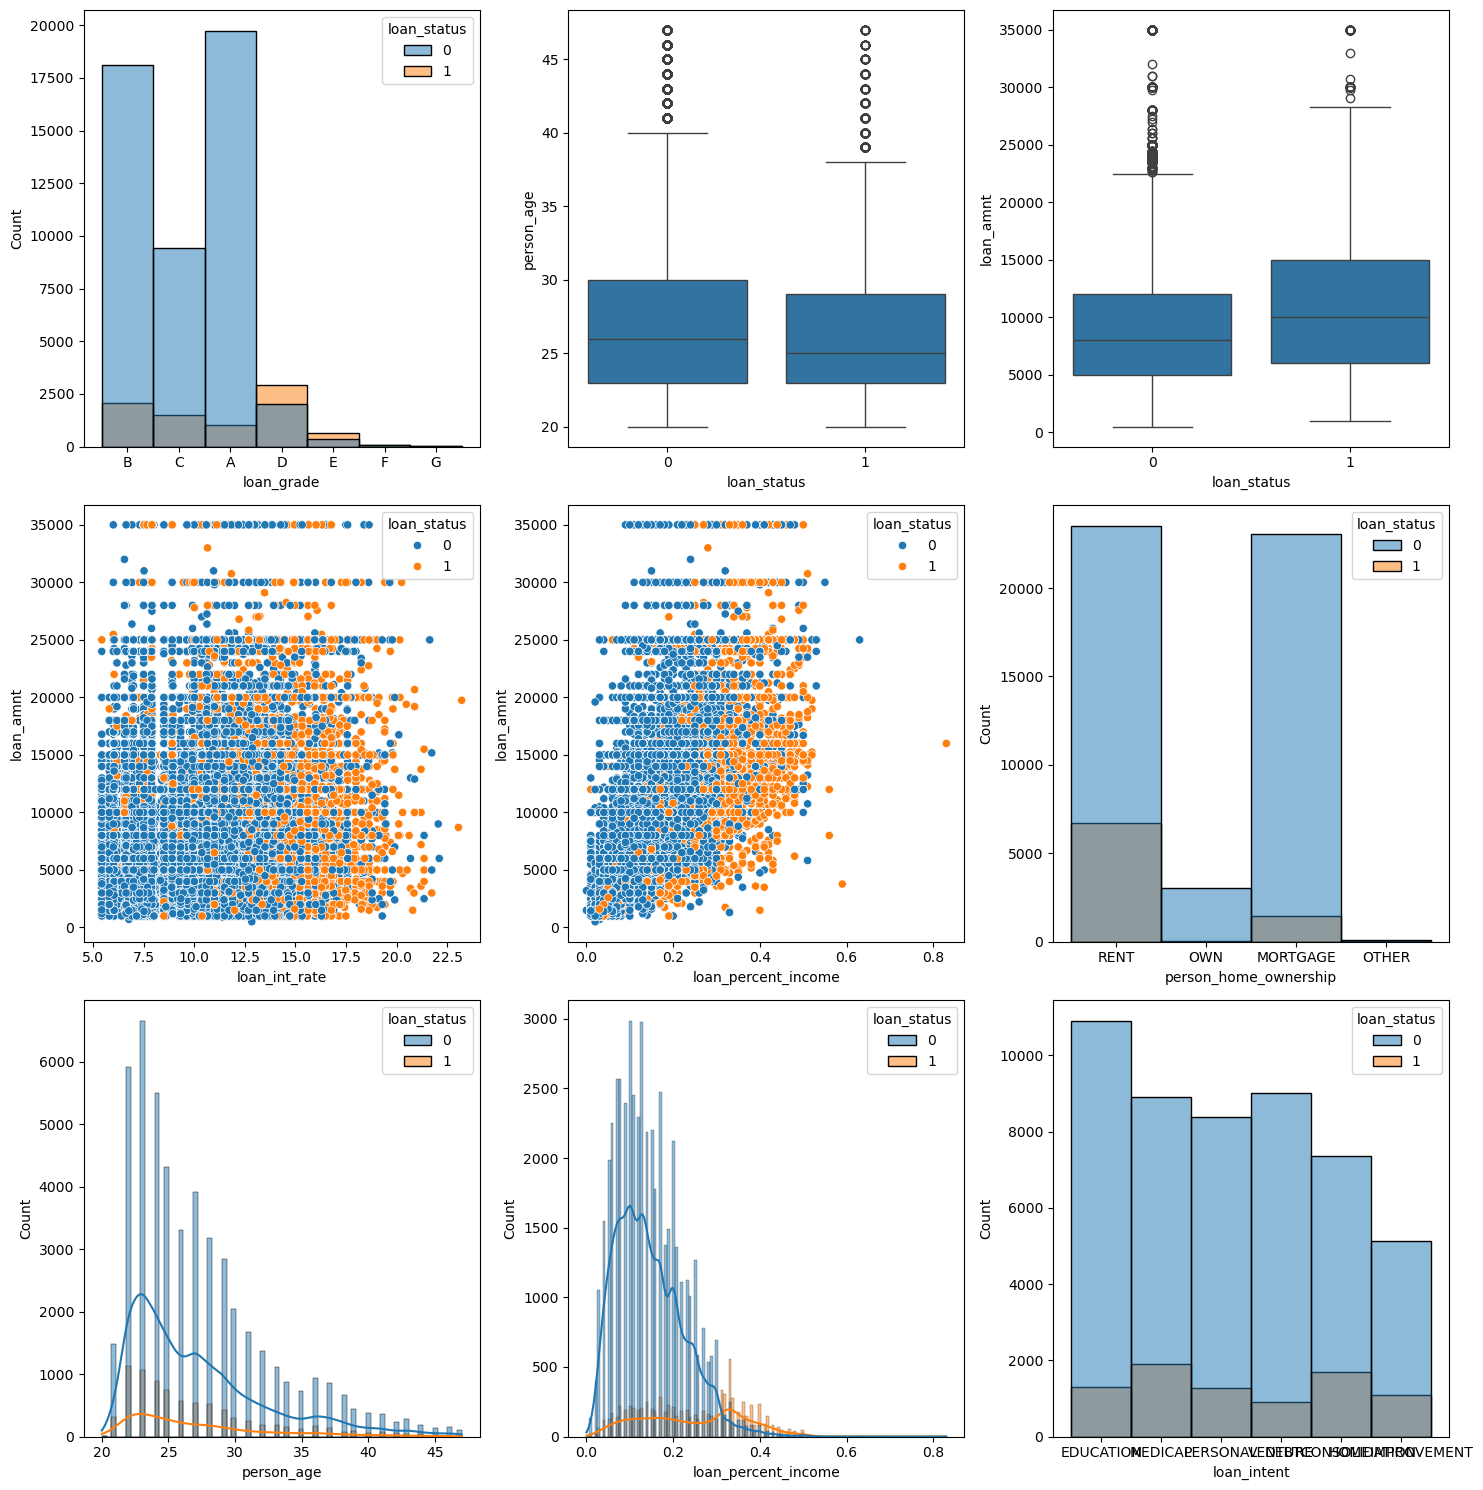

In [100]:
fig, axes = plt.subplots(3, 3, figsize=(15, 15))  # 3 rows and 3 columns

# Hist plot for  person age and loan_status
sns.histplot(x='loan_grade',hue='loan_status', data=train_data_og, ax=axes[0,0])

# Boxplot for person age vs loan status
sns.boxplot(x='loan_status', y='person_age', data=train_data_og, ax=axes[0, 1])

# Boxpot for loan amount vs Loan Status
sns.boxplot(x='loan_status',y='loan_amnt',data=train_data_og,ax=axes[0,2])

# Scatterplot for loan interest rate vs loan amount
sns.scatterplot(x='loan_int_rate', y='loan_amnt', data=train_data_og, hue='loan_status', ax=axes[1, 0])

# Violing plot for  cb_person_cred_hist_length and loan_status
sns.scatterplot(y='loan_amnt',x='loan_percent_income',hue='loan_status', data=train_data_og, ax=axes[1,1])

# Histplot
sns.histplot(x='person_home_ownership',hue='loan_status', data=train_data_og, ax=axes[1,2])

# Hist plot for  person age and loan_status
sns.histplot(x='person_age',hue='loan_status', data=train_data_og,kde=True, ax=axes[2,0])

# Hist plot for  person age and loan_status
sns.histplot(x='loan_percent_income',hue='loan_status', data=train_data_og,kde=True, ax=axes[2,1])

# Hist plot for  person age and loan_status
sns.histplot(x='loan_intent',hue='loan_status', data=train_data_og, ax=axes[2,2])



plt.tight_layout()
plt.show()

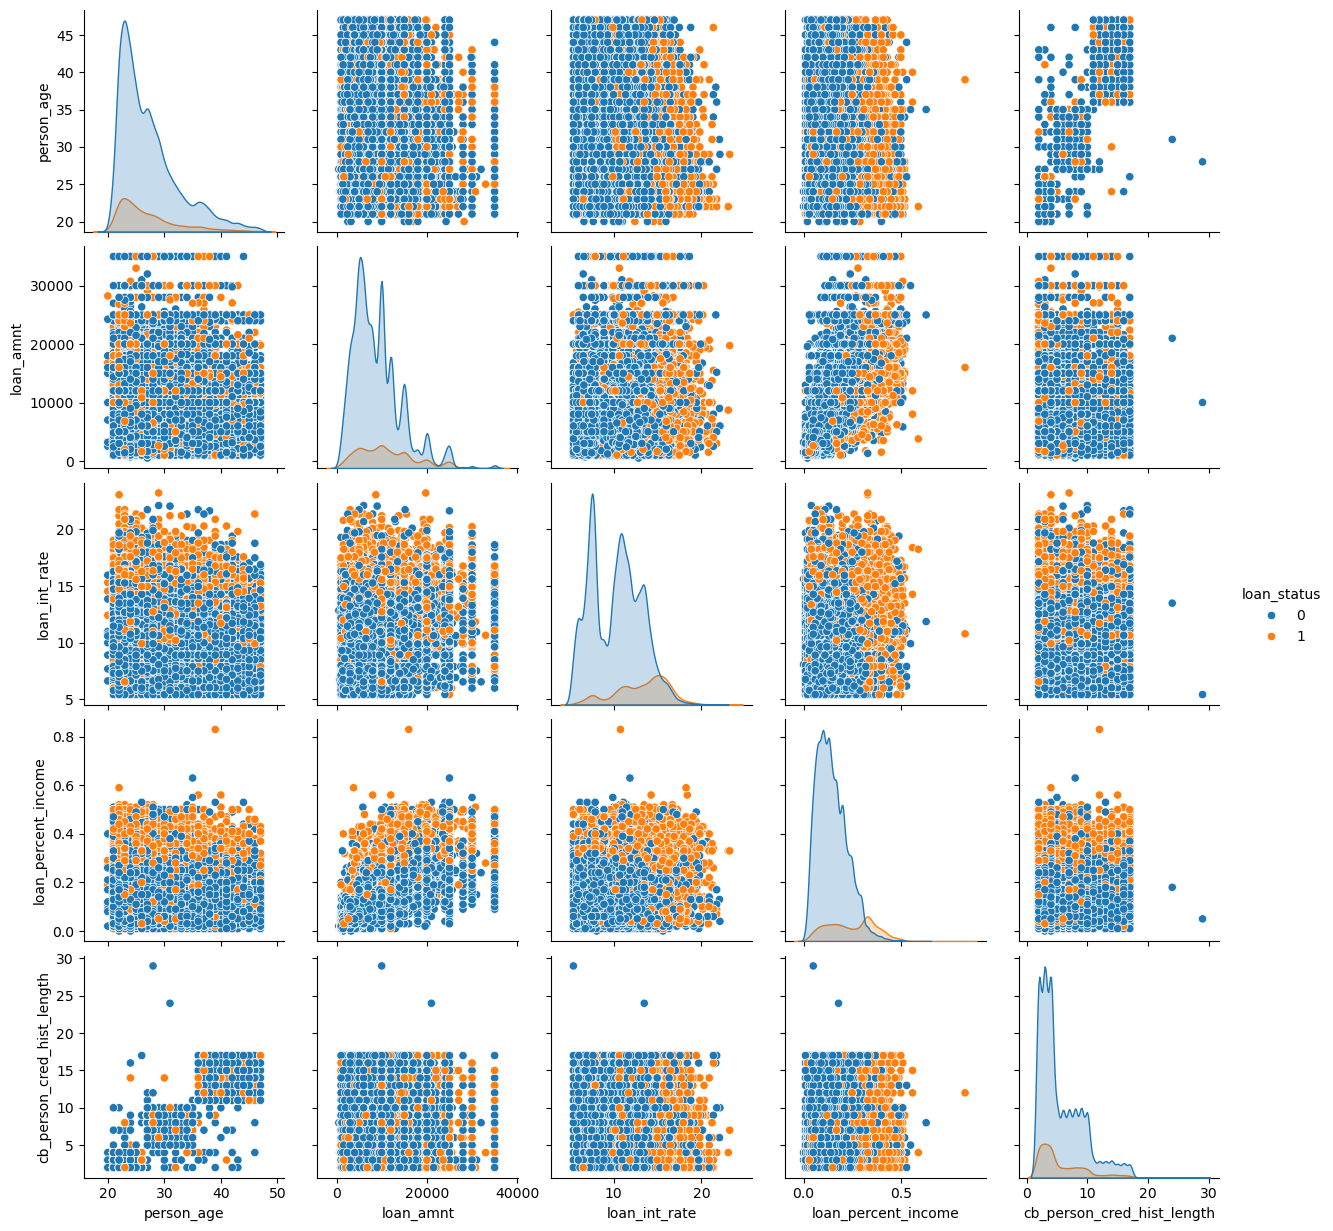

In [92]:
sns.pairplot(train_data_og.drop(columns=['id','person_emp_length','person_income']), hue="loan_status")

# Training The Data

In [ ]:
model = xgb.XGBClassifier(use_label_encoder=False, eval_metric='logloss')
model.fit(X_train, y_train)

/opt/anaconda3/envs/ML/lib/python3.12/site-packages/xgboost/core.py:158: UserWarning: [14:20:46] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=None,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [31]:
y_pred = model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')
print(classification_report(y_test, y_pred))
confusion = confusion_matrix(y_test, y_pred)
print('Confusion Matrix:')
print(confusion)


Accuracy: 0.95
              precision    recall  f1-score   support

           0       0.96      0.99      0.97     10087
           1       0.90      0.75      0.82      1642

    accuracy                           0.95     11729
   macro avg       0.93      0.87      0.90     11729
weighted avg       0.95      0.95      0.95     11729

Confusion Matrix:
[[9957  130]
 [ 416 1226]]
